In [1]:
from datasets import load_from_disk

# Load the dataset from disk
subset = load_from_disk("english_insertions")
print(subset)

DatasetDict({
    train: Dataset({
        features: ['id', 'base_sentence', 'phrase', 'edited_sentence'],
        num_rows: 13737796
    })
})


/home/longnhat/miniconda3/envs/icl_mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompt_list = []

from tqdm import tqdm
base_sents = subset['train']['base_sentence'][:1000]
phrases = subset['train']['phrase'][:1000]
edited_sents = subset['train']['edited_sentence'][:1000]

import gc
del subset
gc.collect()

0

model

In [3]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

# -----------------------------------------------------------------------------

def cosine_sim(v1, v2):
    v1, v2 = v1.squeeze(0), v2.squeeze(0)
    sim = F.cosine_similarity(v1, v2, dim=-1)
    return sim.cpu().detach().numpy()

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x, matching_indices_1st = None, matching_indices_2nd = None):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        if matching_indices_1st is not None and matching_indices_2nd is not None:            
            k_sim = cosine_sim(k[:, :, matching_indices_2nd, :], k[:, :, matching_indices_1st, :])
            q_sim = cosine_sim(q[:, :, matching_indices_2nd, :], q[:, :, matching_indices_1st, :])
            v_sim = cosine_sim(v[:, :, matching_indices_2nd, :], v[:, :, matching_indices_1st, :])

        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y, [q_sim, k_sim, v_sim]

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x, matching_indices_1st = None, matching_indices_2nd = None):
        attn, sims = self.attn(self.ln_1(x), matching_indices_1st, matching_indices_2nd)
        x = x + attn
        # x = x + self.attn(self.ln_1(x), matching_indices_1st, matching_indices_2nd)
        x = x + self.mlp(self.ln_2(x))
        return x, sims

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, matching_indices_1st = None, matching_indices_2nd = None):
        # indices1_list = []
        # indices2_list = []
        q_sims_lsts = []
        k_sims_lsts = []
        v_sims_lsts = []

        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x, sims = block(x, matching_indices_1st, matching_indices_2nd)
            q_sims_lsts.append(sims[0])
            k_sims_lsts.append(sims[1])
            v_sims_lsts.append(sims[2])
            # indices1_list.append(x[:, matching_indices_1st, :])
            # indices2_list.append(x[:, matching_indices_2nd, :])
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits, q_sims_lsts, k_sims_lsts, v_sims_lsts

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import string
from tqdm import tqdm
import numpy as np

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

def preprocessing(text):
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Remove multiple whitespaces
    text = ' '.join(text.split())
    return text

# function to calculate jaccard of two sets
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union

def encode_decode(text, cuda = False, return_ids = False):
    if cuda:
        input_ids = tokenizer.encode(text, return_tensors='pt').to(device)
    else:
        input_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = input_ids[0].tolist()
    decoded_tokens = [tokenizer.decode([token]) for token in tokens]

    if return_ids:
        return decoded_tokens, input_ids
    else:   
        return decoded_tokens

def is_punctuation(token):
    # Consider tokens that are punctuation marks or empty spaces
    return token.strip() in string.punctuation or token.strip() == '' or token.strip() == '\n'

def get_tokens_without_punctuation(tokens):
    tokens_no_punct = []
    indices = []
    for idx, token in enumerate(tokens):
        if not is_punctuation(token):
            tokens_no_punct.append(token)
            indices.append(idx)
    return tokens_no_punct, indices

def find_token_indices(base_tokens, edited_tokens, base_indices, edited_indices):
    matching_indices = []
    edited_pos = 0
    for base_idx, base_token in zip(base_indices, base_tokens):
        found = False
        base_token_stripped = base_token.strip()
        while edited_pos < len(edited_tokens):
            edited_token_stripped = edited_tokens[edited_pos].strip()
            if base_token_stripped == edited_token_stripped:
                matching_indices.append(edited_indices[edited_pos])
                edited_pos += 1
                found = True
                break
            else:
                edited_pos += 1
        if not found:
            return False
    return matching_indices

def find_base_sent(base_sent, prompt):
    base_sentence = encode_decode(base_sent)
    edited_sentence, edited_ids = encode_decode(prompt, cuda=True, return_ids=True)

    # print(f"base: {base_sentence}")
    # print(f"edited: {edited_sentence}")

    # Get tokens and indices without punctuation from base sentence
    base_tokens_no_punct, base_indices_no_punct = get_tokens_without_punctuation(base_sentence)

    idx = len(base_sentence) + 4
    realign_edited_sentence = edited_sentence[:idx]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_1st = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    idx = len(base_sentence) + 3
    realign_edited_sentence = edited_sentence[idx:]
    # Get tokens and indices without punctuation from edited sentence after the base sentence
    edited_tokens_no_punct, edited_indices_no_punct = get_tokens_without_punctuation(realign_edited_sentence)
    # Find the indices of base sentence tokens in the edited sentence
    matching_indices_2nd = find_token_indices(base_tokens_no_punct, edited_tokens_no_punct, base_indices_no_punct, edited_indices_no_punct)

    if matching_indices_1st == False or matching_indices_2nd == False:
        return False, False, False, False

    # add idx to the indices 2nd
    matching_indices_2nd = [i + idx for i in matching_indices_2nd]

    return matching_indices_1st, matching_indices_2nd, edited_ids, edited_sentence

In [5]:
# -----------------------------------------------------------------------------
num_return_sequences = 5
max_length = 30

model_name = 'gpt2'

model = GPT.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()
model = model.to(device)

loading weights from pretrained gpt: gpt2


/home/longnhat/miniconda3/envs/icl_mi/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Sim of non dub tokens

In [6]:
import torch
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def get_top_k(logits, top_k, tokenizer):
  prob = torch.softmax(logits, dim=-1)
  top_tokens = torch.topk(prob, top_k, dim=-1)
  tokens = [tokenizer.decode([idx.item()]) for idx in top_tokens.indices[0]]
  return tokens

def outer_join(a, b):
    a_set = set(a)
    b_set = set(b)

    # Elements in `a` but not in `b`
    a_not_in_b = a_set - b_set
    return list(a_not_in_b)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)


n = 5    # For n=1, should closely resemble Code A's behavior
skiped = 0
top_k = 10
jc_ult = []
first_pred_ult = []
cos_sim_dict_non_dub_q = defaultdict(list)
cos_sim_dict_non_dub_k = defaultdict(list)
cos_sim_dict_non_dub_v = defaultdict(list)

num_word = 0
for i in tqdm(range(1000)):
  # get sentence
  base_sent = preprocessing(base_sents[i])
  phrase = preprocessing(phrases[i])
  edited_sent = preprocessing(edited_sents[i])

  # construct prompt
  prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

  # Find indices in edited sentence
  matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = find_base_sent(base_sent, prompt)

  if matching_indices_1st == False or matching_indices_2nd == False:
    # if failed to find duplicated
    skiped += 1
    continue

  new_1st, new_2nd = [], []
  edited_idx = np.arange(0, len(edited_encoded))
  for idx1, idx2 in zip(matching_indices_1st, matching_indices_2nd):
    current_idx = [idx1, idx2]
    outer_lst = outer_join(edited_idx, current_idx)
    select_idx = random.sample(outer_lst, len(current_idx))

    new_1st.extend(current_idx)
    new_2nd.extend(select_idx)
  
  num_word += len(new_1st)

  # pass to the model
  with torch.no_grad():
    logits, q_sims_lsts, k_sims_lsts, v_sims_lsts = model(input_ids, 
                                                          matching_indices_1st = new_1st,  
                                                          matching_indices_2nd = new_2nd)
  
  # compute cosine sim
  layer = 0
  for q,k,v in zip(q_sims_lsts, k_sims_lsts, v_sims_lsts):
    cos_sim_dict_non_dub_q[layer].extend(q)
    cos_sim_dict_non_dub_k[layer].extend(k)
    cos_sim_dict_non_dub_v[layer].extend(v)
    layer += 1
  
print("\n#failed samples:", skiped)
print("\n#num word:", num_word)

100%|██████████| 1000/1000 [00:06<00:00, 158.81it/s]


#failed samples: 115

#num word: 42308


# Sim of 0/3

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def get_top_k(logits, top_k, tokenizer):
  prob = torch.softmax(logits, dim=-1)
  top_tokens = torch.topk(prob, top_k, dim=-1)
  tokens = [tokenizer.decode([idx.item()]) for idx in top_tokens.indices[0]]
  return tokens

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

n = 5    # For n=1, should closely resemble Code A's behavior
skiped = 0
top_k = 10
jc_ult = []
first_pred_ult = []
cos_sim_dict = defaultdict(list)

num_word = 0


for i in tqdm(range(1000)):
  # get sentence
  base_sent = preprocessing(base_sents[i])
  phrase = preprocessing(phrases[i])
  edited_sent = preprocessing(edited_sents[i])

  # construct prompt
  prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

  # Find indices in edited sentence
  matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = find_base_sent(base_sent, prompt)

  if matching_indices_1st == False or matching_indices_2nd == False:
    # if failed to find duplicated
    skiped += 1
    continue

  new_1st, new_2nd = [], []
  for idx1, idx2 in zip(matching_indices_1st, matching_indices_2nd):
    if edited_encoded[idx1-1] == edited_encoded[idx2-1]:
      if edited_encoded[idx1-2] == edited_encoded[idx2-2]:
        if edited_encoded[idx1-3] == edited_encoded[idx2-3]:
          new_1st.append(idx1)
          new_2nd.append(idx2)
  
  num_word += len(new_1st)
  
  # pass to the model
  with torch.no_grad():
    logits, indices_1st, indices_2nd = model(input_ids, 
                                              matching_indices_1st = new_1st,  
                                              matching_indices_2nd = new_2nd)
  
  # compute cosine sim
  layer = 0
  for first_idx, second_idx in zip(indices_1st, indices_2nd):
    first_idx, second_idx = first_idx.squeeze(0), second_idx.squeeze(0)
    cos_sim = F.cosine_similarity(first_idx, second_idx, dim=-1)
    cos_sim_dict[layer].extend(cos_sim.cpu().detach().numpy())
    layer += 1
  
print("\n#failed samples:", skiped)
print("\n#num word:", num_word)

# Sim All

In [7]:
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def get_top_k(logits, top_k, tokenizer):
  prob = torch.softmax(logits, dim=-1)
  top_tokens = torch.topk(prob, top_k, dim=-1)
  tokens = [tokenizer.decode([idx.item()]) for idx in top_tokens.indices[0]]
  return tokens

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

n = 5    # For n=1, should closely resemble Code A's behavior
skiped = 0
top_k = 10
jc_ult = []
first_pred_ult = []
cos_sim_dict_q = defaultdict(list)
cos_sim_dict_k = defaultdict(list)
cos_sim_dict_v = defaultdict(list)


for i in tqdm(range(1000)):
  # get sentence
  base_sent = preprocessing(base_sents[i])
  phrase = preprocessing(phrases[i])
  edited_sent = preprocessing(edited_sents[i])

  # construct prompt
  prompt = f"Base sentence: {base_sent}\nPhrase to insert: {phrase}\nEdited sentence: {edited_sent}"

  # Find indices in edited sentence
  matching_indices_1st, matching_indices_2nd, input_ids, edited_encoded = find_base_sent(base_sent, prompt)
  if matching_indices_1st == False or matching_indices_2nd == False:
    # if failed to find duplicated
    skiped += 1
    continue

  # pass to the model
  with torch.no_grad():
    logits, q_sims_lsts, k_sims_lsts, v_sims_lsts = model(input_ids, 
                              matching_indices_1st = matching_indices_1st,  
                              matching_indices_2nd = matching_indices_2nd)
  
  # compute cosine sim
  layer = 0
  for q,k,v in zip(q_sims_lsts, k_sims_lsts, v_sims_lsts):
    cos_sim_dict_q[layer].extend(q)
    cos_sim_dict_k[layer].extend(k)
    cos_sim_dict_v[layer].extend(v)
    layer += 1
  
print("/n#failed samples:", skiped)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 178.07it/s]

/n#failed samples: 115


# Plot

In [12]:
len(cos_sim_dict[0][0])

19

KeyboardInterrupt: 

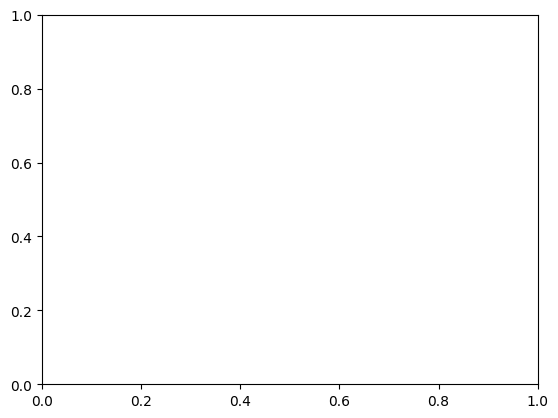

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cos_sim_dict = cos_sim_dict_q
cos_sim_dict_non_dub = cos_sim_dict_non_dub_q

sim_list_total = []
for key, value in cos_sim_dict.items():
  sim_list_total.extend(value)

sim_list_total_non_dub = []
for key, value in cos_sim_dict_non_dub.items():
  sim_list_total_non_dub.extend(value)

# Plot the histogram with KDE
sns.histplot(sim_list_total, bins=30, kde=True, color='blue', label="dub")
sns.histplot(sim_list_total_non_dub, bins=30, kde=True, color='red', label="non dub")

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram for all similarities - {model_name}')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = len(cos_sim_dict.values())  # Number of lists
data = cos_sim_dict.values()
data_nd = cos_sim_dict_non_dub.values()

# Determine grid size (e.g., 2 rows and 3 columns for n=6)
cols = 3
rows = (n + 1) // cols  # Automatically adjusts for number of lists

# Create the grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each list in a subplot
i = 0
for d, nd in zip(data, data_nd):
    axes[i].hist(d, bins=30, color='blue', alpha=0.7)
    axes[i].hist(nd, bins=30, color='red', alpha=0.7)
    axes[i].set_title(f'Layer {i + 1}')
    axes[i].set_xlim(0, 1)  # Assuming data ranges from 0 to 1
    i+=1

# Hide unused subplots if n is not a perfect square
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a global title
fig.suptitle(f'Histograms of {model_name} layers', fontsize=16)

# Show the plot
plt.show()